In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.regularizers import l1_l2
from tensorflow import keras
import tensorflow as tf

from functions import *

pd.set_option('display.float_format', '{:.6f}'.format)

2023-10-30 19:13:59.093376: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-30 19:13:59.753274: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Data

The original dataset has taxa counts as rows and samples as columns. Since the goal here is to predict taxa counts in the same sample I transpose the original data such that one row represents taxa counts from the same sample. 

In [2]:
df = pd.read_csv(df_path, index_col="Unnamed: 0").T

In [3]:
print(df)

              1050608  130468   3589405  355102   1081058  189592   354275   \
E000823.1.8         0        0        0        0        0        0        0   
E000823.2.6         0        0        0        0        0        0        0   
E000823.4.0         0        0        0        0        0        0        0   
E000823.5.0         0        0        0        0        0        0        0   
E000823.5.7         0        0        0        0        0        0        0   
...               ...      ...      ...      ...      ...      ...      ...   
E014086.30.4        0        0        0        0        0        1       11   
E014086.32.4        0        0        0        0        0        0       13   
E014086.33.5        0        0        0        0        0        0        0   
E014086.34.4        0        0        0        0        0        1        0   
E014086.36.0        0        0        0        0        0        0        0   

              4327628  326749   183857   ...  31792

The dataset contains 521 samples of 7244 taxa, most of which are very sparsely populated 

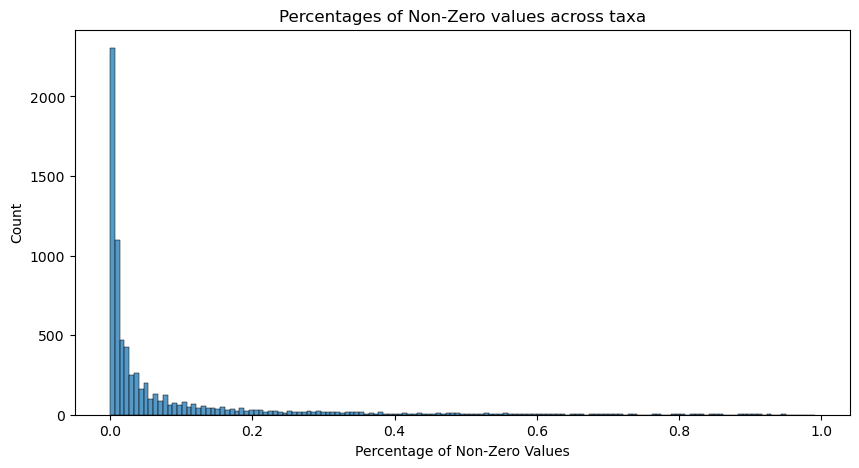

In [4]:
non_zero_value_pcts = calculate_non_zero_value_percentages(df)

plt.figure(figsize=(10,5))
sns.histplot(non_zero_value_pcts)
plt.title("Percentages of Non-Zero values across taxa")
plt.xlabel("Percentage of Non-Zero Values")
plt.show()

### Preprocessing

In [5]:
df = load_and_merge()

In [6]:
min_non_zero_pct = 0.8
window_size = 3
sequence_length = 10

df = load_and_merge()

df = remove_underpopulated_taxa(df, min_non_zero_pct)
df = standard_rolling_average(df, window_size)
df = feature_wise_scaling(df)

In [7]:
df

,865469,585419,564806,262095,583656,560336,182854,581079,559527,513445,...,312140,484304,301578,577170,193233,196664,583117,subject_id,sampling_day,ind_time
E000823.4.0,0.002424,0.000379,0.113394,0.034098,0.580222,0.040000,0.193548,0.000211,0.014423,0.152893,...,0.134670,1.000000,0.169154,0.122840,0.040201,0.059699,0.010154,E000823,120,4.000000
E000823.5.0,0.000958,0.000632,0.117647,0.038716,0.482914,0.034000,0.219355,0.000211,0.015839,0.177686,...,0.131805,0.923267,0.169154,0.155183,0.035804,0.054162,0.010779,E000823,150,5.000000
E000823.5.7,0.000620,0.058665,0.089668,0.081743,0.496305,0.026000,0.122581,0.000633,0.017025,0.095041,...,0.054441,0.834464,0.104478,0.115150,0.034338,0.060045,0.009685,E000823,171,5.700000
E000823.6.7,0.159159,0.135397,0.062047,0.098214,0.320627,0.017000,0.154839,0.036920,0.019506,0.070248,...,0.071633,0.555063,0.119403,0.071113,0.021566,0.035127,0.006092,E000823,201,6.700000
E000823.8.5,0.158651,0.136450,0.046781,0.093596,0.314938,0.036000,0.129032,0.036920,0.047941,0.053719,...,0.051576,0.442354,0.094527,0.083439,0.050251,0.061602,0.037334,E000823,255,8.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E014086.30.4,0.038563,0.005180,0.008506,0.024708,0.274129,0.407000,0.470968,0.063080,0.000475,0.380165,...,0.183381,0.000270,0.358209,0.288137,0.091290,0.127531,0.423113,E014086,912,30.400000
E014086.32.4,0.077127,0.006233,0.005103,0.014778,0.395958,0.603000,0.509677,0.088608,0.002027,0.483471,...,0.530086,0.000231,0.353234,0.426464,0.142169,0.345042,0.622876,E014086,972,32.400000
E014086.33.5,0.098213,0.005728,0.005238,0.011469,0.403894,0.798000,0.470968,0.078270,0.002150,0.512397,...,0.790831,0.000154,0.353234,0.507480,0.213358,0.537809,0.756436,E014086,1005,33.500000
E014086.34.4,0.063201,0.001558,0.003760,0.006542,0.405465,0.868000,0.412903,0.058228,0.001841,0.471074,...,1.000000,0.000039,0.353234,0.571745,0.241625,0.631597,0.749125,E014086,1032,34.400000


### Features and tergets


In [8]:
number_test_sequences = 3

train_feats, train_targets, test_feats, test_targets, test_subjects = feats_and_targets(df, seq_length=sequence_length, n_test_seq=number_test_sequences)

The test subjects are ['E003188' 'E001958' 'E014086']


In [9]:
print(len(train_feats), len(train_targets))

265 265


### The Model

In [10]:
reg = 1e-12
loss=mae_ignore_zeros(false_positives_penalty_factor=0.3)

n_feats = len(df.columns) - 1

model = Sequential()
model.add(keras.Input(shape=(sequence_length, n_feats)))
model.add(keras.layers.LSTM(1024, return_sequences=False, activation='relu'))
model.add(keras.layers.Dense(2048, activation="tanh", kernel_regularizer=l1_l2(reg)))
model.add(keras.layers.Dense(n_feats, activation="relu", kernel_regularizer=l1_l2(reg)))

model.compile(optimizer="Adam", loss=loss, metrics=["mae", "mape"])

model.summary()

2023-10-30 19:14:03.352406: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-30 19:14:03.368595: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-30 19:14:03.368850: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1024)              4362240   
                                                                 
 dense (Dense)               (None, 2048)              2099200   
                                                                 
 dense_1 (Dense)             (None, 40)                81960     
                                                                 
Total params: 6543400 (24.96 MB)
Trainable params: 6543400 (24.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Training and Validation

In [11]:
train_feats = np.asarray(train_feats)

model.fit(x=train_feats, y=train_targets, validation_split=0.05, epochs=100)

Epoch 1/100


2023-10-30 19:14:05.435319: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-30 19:14:05.459729: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f3bac0316f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-30 19:14:05.459755: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2023-10-30 19:14:05.464203: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-30 19:14:05.475190: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-30 19:14:05.573864: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

8/8 [==============================] - 2s 41ms/step - loss: 1861.2865 - mae: 18.2312 - mape: 962995.2500 - val_loss: 1728.6356 - val_mae: 16.9465 - val_mape: 96.5885
Epoch 2/100
8/8 [==============================] - 0s 15ms/step - loss: 1767.0151 - mae: 17.3715 - mape: 96.7674 - val_loss: 1683.0000 - val_mae: 16.5267 - val_mape: 96.6626
Epoch 3/100
8/8 [==============================] - 0s 16ms/step - loss: 1723.0253 - mae: 16.9610 - mape: 96.7521 - val_loss: 1639.5730 - val_mae: 16.1160 - val_mape: 96.5592
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 1680.8492 - mae: 16.5588 - mape: 96.6544 - val_loss: 1597.2675 - val_mae: 15.7080 - val_mape: 96.4216
Epoch 5/100
8/8 [==============================] - 0s 16ms/step - loss: 1639.6283 - mae: 16.1605 - mape: 96.5948 - val_loss: 1558.2434 - val_mae: 15.3276 - val_mape: 96.4006
Epoch 6/100
8/8 [==============================] - 0s 15ms/step - loss: 1601.2627 - mae: 15.7802 - mape: 96.5305 - val_loss: 1520.1604 - v

In [12]:
test_subjects

array(['E003188', 'E001958', 'E014086'], dtype=object)

In [16]:
def fetch_subject_y_true_and_y_pred(test_subjects, model, df, target_subject_idx, test_feats, test_targets):
    
    cols = list(df.columns)[:-1]
    
    target_subject = test_subjects[target_subject_idx]

    test_subject_feats = np.asarray(test_feats[target_subject])
    test_subject_targets_df = pd.concat(test_targets[target_subject], axis=1).T
    
    test_subject_targets_df.columns = cols
    test_subject_y_pred = model.predict(test_subject_feats)
    
    test_subject_y_pred_df = pd.DataFrame(test_subject_y_pred)
    test_subject_y_pred_df.columns = cols
    test_subject_y_pred_df.index = test_subject_targets_df.index

    return test_subject_targets_df, test_subject_y_pred_df

In [18]:
target_subject_idx = 0
target_subject = test_subjects[target_subject_idx]

test_subject_targets_df, test_subject_y_pred_df = fetch_subject_y_true_and_y_pred(test_subjects, model, df, target_subject_idx, test_feats, test_targets)

test_subject_y_pred_df

1/1 [==============================] - 0s 108ms/step


,865469,585419,564806,262095,583656,560336,182854,581079,559527,513445,...,3426658,312140,484304,301578,577170,193233,196664,583117,subject_id,sampling_day
E003188.11.6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,654.499939,23.781210
E003188.12.6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,654.499939,23.781210
E003188.14.4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,654.499939,23.781210
E003188.14.9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,654.499939,23.781210
E003188.15.7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,654.499939,23.781210
E003188.16.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,654.499939,23.781210
E003188.17.4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,654.499939,23.781210
E003188.18.9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,654.499939,23.781210
E003188.20.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,654.499939,23.781210
E003188.21.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,654.499939,23.781210


Usually at least some of the taxa are not predictable by a model. Then it returns zeros for their entire sequence

In [ ]:
non_predicted_taxa = [col for col in test_subject_y_pred_df.columns if all(test_subject_y_pred_df[col] == 0.0)]
n_non_predicted_taxa = len(non_predicted_taxa)

print(f"Total taxa not predicted: {non_predicted_taxa}, {(n_non_predicted_taxa/len(test_subject_targets_df.columns)) * 100}% of all taxa")

The next section allows to examine individual true and predicted sequences

In [ ]:
target_taxa = 865469
target_subject_idx = 0

target_subject = test_subjects[target_subject_idx]

true_sequence = test_subject_targets_df[target_taxa].reset_index(drop=True)
pred_sequence = test_subject_y_pred_df[target_taxa].reset_index(drop=True)

sequence_comparisson_graphs(true_sequence, pred_sequence, target_taxa)

Now I look at the performance across different sequences and test subjects. Errors are calculated individually by test subjects and then averaged

In [ ]:
subjects_error_dfs = []
for target_subject_idx in range(len(test_subjects)):
    
    test_subject_targets_df, test_subject_y_pred_df = fetch_subject_y_true_and_y_pred(test_subjects, model, df, target_subject_idx, test_feats, test_targets, experiment_id=1)

    errors_df = calculate_percentage_errors(test_subject_y_pred_df, test_subject_targets_df)
    subjects_error_dfs.append(errors_df)
    
errors_df = pd.concat(subjects_error_dfs)

In [ ]:
percentile_graph(errors_df, "accross all taxa LSTM SEQUENCE ON SEQUENCE", y_top_lim=2)

Same graph, but only for those taxa that are not all predicted zero

In [ ]:
only_predicted_taxa = test_subject_y_pred_df.columns[~(test_subject_y_pred_df.columns.isin(non_predicted_taxa))].drop(['subject_id', 'sampling_day'])
only_predicted_errors = errors_df[only_predicted_taxa]
only_predicted_errors.describe()

In [ ]:
percentile_graph(only_predicted_errors, "accross successfully predicted taxa", y_top_lim=1)

In [ ]:
plt.hist(only_predicted_errors.median().clip(0, 1))
plt.show()

## Errors versus feature populations

In [ ]:
population_rates = calculate_non_zero_value_percentages(df).drop(['subject_id', 'sampling_day'])

What are the average population rates in the taxa that are predicted by this model compared to the ones that arent?

In [ ]:
population_rates[non_predicted_taxa].mean()

In [ ]:
population_rates[only_predicted_taxa].mean()

Among the predicted taxa, is the median error somehow related to the population rate?

In [ ]:
only_predicted_errors.median()

In [ ]:
median_errors_by_population_rate(df, only_predicted_errors, only_predicted_taxa)